# Modified 3D PMRNN

## Module Imports

In [1]:
# import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import os
import cv2
import import_ipynb
import Utils
# from skimage import util


In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.5.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from tensorflow.keras import layers,losses,Sequential,metrics
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
from CBAM import ConvolutionBlockAttentionModule

In [6]:
from tensorflow.keras import backend as K

In [7]:
import tensorflow._api.v2.compat.v1 as tf1

In [8]:
# tf1.disable_v2_behavior()

## reading data

In [9]:
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

(1000, 1000, 1000)

## Voxel extraction 

In [10]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

(64, 250, 256, 256, 1)

In [11]:
del image_data

## Loss Functions

In [12]:
def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kld = tf.keras.losses.KLDivergence()
        kl_loss = kld(model.inferenceDistribution,model.learnedDistribution)
        return kl_loss
    return _calculate_kl_loss

def _calculate_reconstruction_loss(y_target, y_predicted):
    mse = losses.MeanSquaredError()
    reconstruction_loss = mse( y_target, y_predicted )
    return reconstruction_loss


def _calculate_porosity_loss(y_target,y_predicted):
    por1 = tf.reduce_mean(y_target,axis=(1, 2))
    por2 = tf.reduce_mean(y_predicted,axis=(1, 2))
    mae = losses.MeanSquaredError()
    return mae(por1,por2)
    

## Model Class

In [13]:
class Reconstruction():
    """
    Reconstruction represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 inputShape=(256,256,1),
                 latent_space_dim = 64,
                 reducedDimension = 256,
                 convFilters = [16,32,64,128,256]
                )-> None:
        
        
        
        ##### inputs ######
        self.inputShape = inputShape # [256, 256, 1]
        self.latent_space_dim = latent_space_dim # 64
        self.reducedDimension = reducedDimension #256
        
        ##### Loss weights ######
        self.reconstruction_loss_weight = 1
        self.Kullback_leibler_weight = 0.001
        self.porosity_Loss_weight = 1
        
        self.skipConnections = None

        self.learnedPrior = None
        self.inference = None
        self.Generate = None

        
        
        self.learnedDistribution = None
        self.inferenceDistribution = None
        
        self._build()

    def summary(self):
        self.learnedPrior.summary()
        self.inference.summary()
        self.Generate.summary()
    
    def compile(self, learning_rate=0.0001):
        optimizer = Adam(learning_rate=learning_rate)
        self.Generate.compile(optimizer=optimizer,
                           loss=self._calculate_combined_loss,
                           metrics=[_calculate_reconstruction_loss,
                                    _calculate_porosity_loss,
                                    calculate_kl_loss(self)],
                             experimental_run_tf_function=False)
    
    def train(self, inputs1,inputs2, batch_size, num_epochs):
        return self.Generate.fit(x=[inputs1,inputs2],
                       y=inputs2,
                       batch_size=batch_size,
                       epochs=num_epochs,
                       )
    
#     def save(self, save_folder="."):
#         self._create_folder_if_it_doesnt_exist(save_folder)
#         self._save_parameters(save_folder)
#         self._save_weights(save_folder)

#     def load_weights(self, weights_path):
#         self.model.load_weights(weights_path)


#      @classmethod
#     def load(cls, save_folder="."):
#         parameters_path = os.path.join(save_folder, "parameters.pkl")
#         with open(parameters_path, "rb") as f:
#             parameters = pickle.load(f)
#         autoencoder = Reconstruction(*parameters)
#         weights_path = os.path.join(save_folder, "weights.h5")
#         autoencoder.load_weights(weights_path)
#         return autoencoder

    def _calculate_combined_loss(self, y_target, y_predicted):
        
        
        reconstruction_loss = _calculate_reconstruction_loss(y_target,y_predicted)
        kl_loss = calculate_kl_loss(self)(self.inferenceDistribution, self.learnedDistribution)
        porisity_loss = _calculate_porosity_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
                                                         + kl_loss * self.Kullback_leibler_weight\
                                                         + porisity_loss * self.porosity_Loss_weight
        return combined_loss
    


    def _build(self):
        self._build_inference()
        self._build_learned_prior()
        self._build_generate()
    
    ######  inference ########
    
    
        
    def _build_inference(self):
        inference_input = layers.Input(shape=self.inputShape, name="inference_input")
        
        conv_1 = layers.Conv2D(16, (3,3) ,input_shape = self.inputShape , activation='relu',
                               padding='same' , name="first_encoder_conv")(inference_input)
        bn1 = layers.BatchNormalization()(conv_1)
        mp1 = layers.MaxPooling2D((2,2), padding='same')(bn1)
        
        
        conv_2 = layers.Conv2D(32, (3,3) , activation='relu'
                               , padding='same' , name="second_encoder_conv" )(mp1)
        bn2 = layers.BatchNormalization()(conv_2)
        mp2 = layers.MaxPooling2D((2,2), padding='same')(bn2)
        
        
        conv_3 = layers.Conv2D(64, (3,3) , activation='relu'
                               , padding='same', name="third_encoder_conv")(mp2)
        bn3 = layers.BatchNormalization()(conv_3)
        mp3 = layers.MaxPooling2D((2,2), padding='same')(bn3)
        
        
        
        conv_4 = layers.Conv2D(128, (3,3) , activation='relu'
                               , padding='same' , name="fourth_encoder_conv")(mp3)
        bn4 = layers.BatchNormalization()(conv_4)
        mp4 = layers.MaxPooling2D((2,2), padding='same')(bn4)
        
        
        
        conv_5 = layers.Conv2D(256, (3,3), activation='relu'
                               , padding='same' , name="fifth_encoder_conv")(mp4)
        bn5 = layers.BatchNormalization()(conv_5)
        mp5 = layers.MaxPooling2D((2,2), padding='same')(bn5)
        
        flattened = layers.Flatten()(mp5)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
    
        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        inferenceDist = layers.LSTM(self.latent_space_dim, return_sequences=True, name="inference_LSTM")(reshaped)
       
        self.inference = Model(inference_input, inferenceDist, name="inference")
        
        
    ######   learned prior ########
        
    def _build_learned_prior(self):
        learned_input = layers.Input(shape=self.inputShape, name="learned_prior_input")
        
        
        conv_1 = layers.Conv2D(16, (3,3) ,input_shape = self.inputShape , activation='relu',
                               padding='same' , name="first_encoder_conv")(learned_input)
        bn1 = layers.BatchNormalization()(conv_1)
        mp1 = layers.MaxPooling2D((2,2), padding='same')(bn1)
        
        
        conv_2 = layers.Conv2D(32, (3,3) , activation='relu'
                               , padding='same' , name="second_encoder_conv" )(mp1)
        bn2 = layers.BatchNormalization()(conv_2)
        mp2 = layers.MaxPooling2D((2,2), padding='same')(bn2)
        
        
        conv_3 = layers.Conv2D(64, (3,3) , activation='relu'
                               , padding='same', name="third_encoder_conv")(mp2)
        bn3 = layers.BatchNormalization()(conv_3)
        mp3 = layers.MaxPooling2D((2,2), padding='same')(bn3)
        
        
        
        conv_4 = layers.Conv2D(128, (3,3) , activation='relu'
                               , padding='same' , name="fourth_encoder_conv")(mp3)
        bn4 = layers.BatchNormalization()(conv_4)
        mp4 = layers.MaxPooling2D((2,2), padding='same')(bn4)
        
        
        
        conv_5 = layers.Conv2D(256, (3,3), activation='relu'
                               , padding='same' , name="fifth_encoder_conv")(mp4)
        bn5 = layers.BatchNormalization()(conv_5)
        mp5 = layers.MaxPooling2D((2,2), padding='same')(bn5)
        
        flattened = layers.Flatten()(mp5)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        
        
        
        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        learned_dist = layers.LSTM(self.latent_space_dim, return_sequences=True,name="learned_LSTM")(reshaped)
        self.learnedPrior = Model(learned_input, learned_dist, name="learned_prior")
    
    #### generate ######
    
    def _build_generate(self):
        

        
        input_learned = layers.Input(shape=self.inputShape, name="learned_input")
        input_inference = layers.Input(shape=self.inputShape, name="inference_input")
        

        
        self.learnedDistribution = self.learnedPrior(input_learned)
        self.inferenceDistribution = self.inference(input_inference)
        
        
        
        
        conv_1 = layers.Conv2D(16, (3,3) ,input_shape = self.inputShape , activation='relu',
                               padding='same' , name="first_encoder_conv")(input_learned)
        bn1 = layers.BatchNormalization()(conv_1)
        mp1 = layers.MaxPooling2D((2,2), padding='same')(bn1)
        
        
        conv_2 = layers.Conv2D(32, (3,3) , activation='relu'
                               , padding='same' , name="second_encoder_conv" )(mp1)
        bn2 = layers.BatchNormalization()(conv_2)
        mp2 = layers.MaxPooling2D((2,2), padding='same')(bn2)
        
        
        conv_3 = layers.Conv2D(64, (3,3) , activation='relu'
                               , padding='same', name="third_encoder_conv")(mp2)
        bn3 = layers.BatchNormalization()(conv_3)
        mp3 = layers.MaxPooling2D((2,2), padding='same')(bn3)
        
        
        
        conv_4 = layers.Conv2D(128, (3,3) , activation='relu'
                               , padding='same' , name="fourth_encoder_conv")(mp3)
        bn4 = layers.BatchNormalization()(conv_4)
        mp4 = layers.MaxPooling2D((2,2), padding='same')(bn4)
        
        
        
        conv_5 = layers.Conv2D(256, (3,3), activation='relu'
                               , padding='same' , name="fifth_encoder_conv")(mp4)
        bn5 = layers.BatchNormalization()(conv_5)
        mp5 = layers.MaxPooling2D((2,2), padding='same')(bn5)
        
        flattened = layers.Flatten()(mp5)
        
        latentDense = layers.Dense(self.reducedDimension,name ="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)
        self.skipConnections = [bn5,bn4,bn3,bn2,bn1]
        
        temp = layers.Reshape(( 1 ,self.reducedDimension ))(conv_out)
        
        concated_input = layers.Concatenate(axis=-1)([temp,self.learnedDistribution])
        
        reshaped = layers.Reshape((1, self.reducedDimension + self.latent_space_dim))(concated_input)
        
        generated = layers.LSTM(self.reducedDimension, return_sequences=True,name="generate_LSTM")(reshaped)
        
        upDense = layers.Dense(8*8*256,name="up_dense")(generated)
        batchNorm_7 = layers.BatchNormalization()(upDense)
        
        reshapedUp = layers.Reshape((8, 8, 256))(batchNorm_7)
        
        convT_1 = layers.Conv2DTranspose(256, (3,3), strides=2, activation='relu'
                                         , padding='same',name="first_decoder_conv")(reshapedUp)
        batchNorm_8 = layers.BatchNormalization()(convT_1)
        batchNorm_8 = layers.Add()([batchNorm_8,self.skipConnections[0]])
        
        cbam_1 = ConvolutionBlockAttentionModule()(batchNorm_8)
        convT_2 = layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu'
                                         , padding='same',name="second_decoder_conv")(cbam_1)
        batchNorm_9 = layers.BatchNormalization()(convT_2)
        batchNorm_9 = layers.Add()([batchNorm_9, self.skipConnections[1]])
        
        
        cbam_2 = ConvolutionBlockAttentionModule()(batchNorm_9)
        convT_3 = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu'
                                         , padding='same',name="third_decoder_conv")(cbam_2)
        batchNorm_10 = layers.BatchNormalization()(convT_3)
        batchNorm_10 = layers.Add()([batchNorm_10, self.skipConnections[2]])
        
        
        
        cbam_3 = ConvolutionBlockAttentionModule()(batchNorm_10)
        convT_4 = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu'
                                         , padding='same',name="fourth_decoder_conv")(cbam_3)
        batchNorm_11 = layers.BatchNormalization()(convT_4)
        batchNorm_11 = layers.Add()([batchNorm_11, self.skipConnections[3]])
        
        
        cbam_4 = ConvolutionBlockAttentionModule()(batchNorm_11)
        convT_5 = layers.Conv2DTranspose(16, (3,3), strides=2, activation='relu'
                                         , padding='same',name="fifth_decoder_conv")(cbam_4)
        batchNorm_12 = layers.BatchNormalization()(convT_5)
        batchNorm_12 = layers.Add()([batchNorm_12, self.skipConnections[4]])
        
        
        
        gen_out = layers.Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same')(batchNorm_12)
        
        self.Generate = Model([input_learned,input_inference], gen_out, name="generate")

## TensorFlow gpu setup

In [14]:
device = tf.config.list_physical_devices("GPU")
print(device)
tf.config.experimental.set_memory_growth(device[0],True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [16]:
tf.keras.backend.clear_session()

## Model creation

In [17]:
reconstruction = Reconstruction()
reconstruction.summary()
reconstruction.compile()
batch_size = 10
epochs = 10

# for voxel in X_train:
#     reconstruction.train(voxel, batch_size, epochs)

Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
first_encoder_conv (Conv2D)  (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
second_encoder_conv (Conv2D) (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128, 128, 32)      128       
_______________________________________________

## train and test data extraction

In [18]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [19]:
import numpy as np
print(np.__version__)

1.19.5


In [20]:
del voxels

## Creating model input

In [21]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)

## Training the model

In [22]:
histories = []
for i in range(len(learnedVoxels)):
    histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i], batch_size, epochs))

Train on 249 samples
Epoch 1/10
249/249 [==============================] - 18s 71ms/sample - loss: 0.3669 - _calculate_reconstruction_loss: 0.2784 - _calculate_porosity_loss: 0.0566 - _calculate_kl_loss: 31.5698
Epoch 2/10
249/249 [==============================] - 8s 30ms/sample - loss: 0.2165 - _calculate_reconstruction_loss: 0.1472 - _calculate_porosity_loss: 0.0397 - _calculate_kl_loss: 29.4234
Epoch 3/10
249/249 [==============================] - 8s 31ms/sample - loss: 0.1519 - _calculate_reconstruction_loss: 0.0973 - _calculate_porosity_loss: 0.0262 - _calculate_kl_loss: 28.3508
Epoch 4/10
249/249 [==============================] - 7s 28ms/sample - loss: 0.1198 - _calculate_reconstruction_loss: 0.0738 - _calculate_porosity_loss: 0.0183 - _calculate_kl_loss: 27.7287
Epoch 5/10
249/249 [==============================] - 7s 29ms/sample - loss: 0.1011 - _calculate_reconstruction_loss: 0.0599 - _calculate_porosity_loss: 0.0134 - _calculate_kl_loss: 27.8043
Epoch 6/10
249/249 [========

249/249 [==============================] - 8s 30ms/sample - loss: 0.0405 - _calculate_reconstruction_loss: 0.0163 - _calculate_porosity_loss: 3.8261e-05 - _calculate_kl_loss: 24.1405
Epoch 5/10
249/249 [==============================] - 8s 32ms/sample - loss: 0.0390 - _calculate_reconstruction_loss: 0.0152 - _calculate_porosity_loss: 4.6437e-05 - _calculate_kl_loss: 23.8035
Epoch 6/10
249/249 [==============================] - 8s 30ms/sample - loss: 0.0375 - _calculate_reconstruction_loss: 0.0143 - _calculate_porosity_loss: 4.7100e-05 - _calculate_kl_loss: 23.0821
Epoch 7/10
249/249 [==============================] - 8s 31ms/sample - loss: 0.0363 - _calculate_reconstruction_loss: 0.0137 - _calculate_porosity_loss: 4.3946e-05 - _calculate_kl_loss: 22.5732
Epoch 8/10
249/249 [==============================] - 7s 28ms/sample - loss: 0.0353 - _calculate_reconstruction_loss: 0.0130 - _calculate_porosity_loss: 4.5509e-05 - _calculate_kl_loss: 22.2917
Epoch 9/10
249/249 [=====================

249/249 [==============================] - 8s 31ms/sample - loss: 0.0383 - _calculate_reconstruction_loss: 0.0135 - _calculate_porosity_loss: 7.1567e-05 - _calculate_kl_loss: 24.7600
Epoch 7/10
249/249 [==============================] - 7s 28ms/sample - loss: 0.0369 - _calculate_reconstruction_loss: 0.0129 - _calculate_porosity_loss: 7.3823e-05 - _calculate_kl_loss: 23.8911
Epoch 8/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0361 - _calculate_reconstruction_loss: 0.0123 - _calculate_porosity_loss: 6.2484e-05 - _calculate_kl_loss: 23.7327
Epoch 9/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0362 - _calculate_reconstruction_loss: 0.0119 - _calculate_porosity_loss: 5.6428e-05 - _calculate_kl_loss: 24.2134
Epoch 10/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0345 - _calculate_reconstruction_loss: 0.0115 - _calculate_porosity_loss: 5.8676e-05 - _calculate_kl_loss: 22.8826
Train on 249 samples
Epoch 1/10
249/249 

249/249 [==============================] - 7s 28ms/sample - loss: 0.0369 - _calculate_reconstruction_loss: 0.0127 - _calculate_porosity_loss: 1.4949e-05 - _calculate_kl_loss: 24.2423
Epoch 9/10
249/249 [==============================] - 7s 29ms/sample - loss: 0.0365 - _calculate_reconstruction_loss: 0.0124 - _calculate_porosity_loss: 1.2601e-05 - _calculate_kl_loss: 24.1320
Epoch 10/10
249/249 [==============================] - 7s 28ms/sample - loss: 0.0350 - _calculate_reconstruction_loss: 0.0119 - _calculate_porosity_loss: 1.2260e-05 - _calculate_kl_loss: 23.0323
Train on 249 samples
Epoch 1/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0481 - _calculate_reconstruction_loss: 0.0243 - _calculate_porosity_loss: 4.7864e-05 - _calculate_kl_loss: 23.6970
Epoch 2/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0423 - _calculate_reconstruction_loss: 0.0195 - _calculate_porosity_loss: 3.6300e-05 - _calculate_kl_loss: 22.7525
Epoch 3/10
249/249 

249/249 [==============================] - 8s 30ms/sample - loss: 0.0311 - _calculate_reconstruction_loss: 0.0117 - _calculate_porosity_loss: 1.5136e-05 - _calculate_kl_loss: 19.4305
Train on 249 samples
Epoch 1/10
249/249 [==============================] - 8s 30ms/sample - loss: 0.0471 - _calculate_reconstruction_loss: 0.0249 - _calculate_porosity_loss: 1.2512e-05 - _calculate_kl_loss: 22.1261
Epoch 2/10
249/249 [==============================] - 8s 30ms/sample - loss: 0.0413 - _calculate_reconstruction_loss: 0.0196 - _calculate_porosity_loss: 1.2929e-05 - _calculate_kl_loss: 21.6397
Epoch 3/10
249/249 [==============================] - 7s 30ms/sample - loss: 0.0383 - _calculate_reconstruction_loss: 0.0171 - _calculate_porosity_loss: 1.9455e-05 - _calculate_kl_loss: 21.2061
Epoch 4/10
249/249 [==============================] - 8s 31ms/sample - loss: 0.0367 - _calculate_reconstruction_loss: 0.0155 - _calculate_porosity_loss: 1.6916e-05 - _calculate_kl_loss: 21.1280
Epoch 5/10
249/249 [

249/249 [==============================] - 7s 28ms/sample - loss: 0.0397 - _calculate_reconstruction_loss: 0.0180 - _calculate_porosity_loss: 2.8367e-05 - _calculate_kl_loss: 21.7112
Epoch 3/10
249/249 [==============================] - 7s 30ms/sample - loss: 0.0371 - _calculate_reconstruction_loss: 0.0156 - _calculate_porosity_loss: 3.4997e-05 - _calculate_kl_loss: 21.5141
Epoch 4/10
249/249 [==============================] - 8s 30ms/sample - loss: 0.0348 - _calculate_reconstruction_loss: 0.0142 - _calculate_porosity_loss: 3.5258e-05 - _calculate_kl_loss: 20.5738
Epoch 5/10
249/249 [==============================] - 7s 29ms/sample - loss: 0.0333 - _calculate_reconstruction_loss: 0.0131 - _calculate_porosity_loss: 3.3351e-05 - _calculate_kl_loss: 20.0896
Epoch 6/10
249/249 [==============================] - 8s 33ms/sample - loss: 0.0322 - _calculate_reconstruction_loss: 0.0126 - _calculate_porosity_loss: 3.3632e-05 - _calculate_kl_loss: 19.5742
Epoch 7/10
249/249 [=====================

249/249 [==============================] - 7s 30ms/sample - loss: 0.0340 - _calculate_reconstruction_loss: 0.0147 - _calculate_porosity_loss: 2.5486e-05 - _calculate_kl_loss: 19.2476
Epoch 5/10
249/249 [==============================] - 7s 30ms/sample - loss: 0.0326 - _calculate_reconstruction_loss: 0.0138 - _calculate_porosity_loss: 1.9173e-05 - _calculate_kl_loss: 18.7832
Epoch 6/10
249/249 [==============================] - 8s 30ms/sample - loss: 0.0316 - _calculate_reconstruction_loss: 0.0131 - _calculate_porosity_loss: 1.7435e-05 - _calculate_kl_loss: 18.4580
Epoch 7/10
249/249 [==============================] - 8s 31ms/sample - loss: 0.0307 - _calculate_reconstruction_loss: 0.0126 - _calculate_porosity_loss: 1.7325e-05 - _calculate_kl_loss: 18.0702
Epoch 8/10
249/249 [==============================] - 8s 31ms/sample - loss: 0.0294 - _calculate_reconstruction_loss: 0.0120 - _calculate_porosity_loss: 1.3533e-05 - _calculate_kl_loss: 17.3953
Epoch 9/10
249/249 [=====================

249/249 [==============================] - 7s 27ms/sample - loss: 0.0318 - _calculate_reconstruction_loss: 0.0132 - _calculate_porosity_loss: 9.5293e-06 - _calculate_kl_loss: 18.5528
Epoch 7/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0310 - _calculate_reconstruction_loss: 0.0126 - _calculate_porosity_loss: 8.0790e-06 - _calculate_kl_loss: 18.4508
Epoch 8/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0307 - _calculate_reconstruction_loss: 0.0123 - _calculate_porosity_loss: 7.8677e-06 - _calculate_kl_loss: 18.4121
Epoch 9/10
249/249 [==============================] - 7s 27ms/sample - loss: 0.0296 - _calculate_reconstruction_loss: 0.0118 - _calculate_porosity_loss: 6.5204e-06 - _calculate_kl_loss: 17.8529
Epoch 10/10
249/249 [==============================] - 7s 28ms/sample - loss: 0.0286 - _calculate_reconstruction_loss: 0.0114 - _calculate_porosity_loss: 6.5100e-06 - _calculate_kl_loss: 17.1732


## Testing the model

In [23]:

first  = X_test[0]
Topredict = first[1:]
test = first[:-1]


In [24]:
predicted = []


# for i in range(10):
predicted = reconstruction.Generate.predict([test,Topredict])
# predicted.append(nextLayer)
# #     inputLayer = nextLayer
# predicted.append()

D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [25]:
len(predicted)

249

In [ ]:
# sess = tf.compat.v1.Session()
# predictedValues = []
# for i in range (10):
# # Evaluate the tensor and get its value
#     predictedValues.append(sess.run(predicted[i+1]))


# # Close the session
# sess.close()

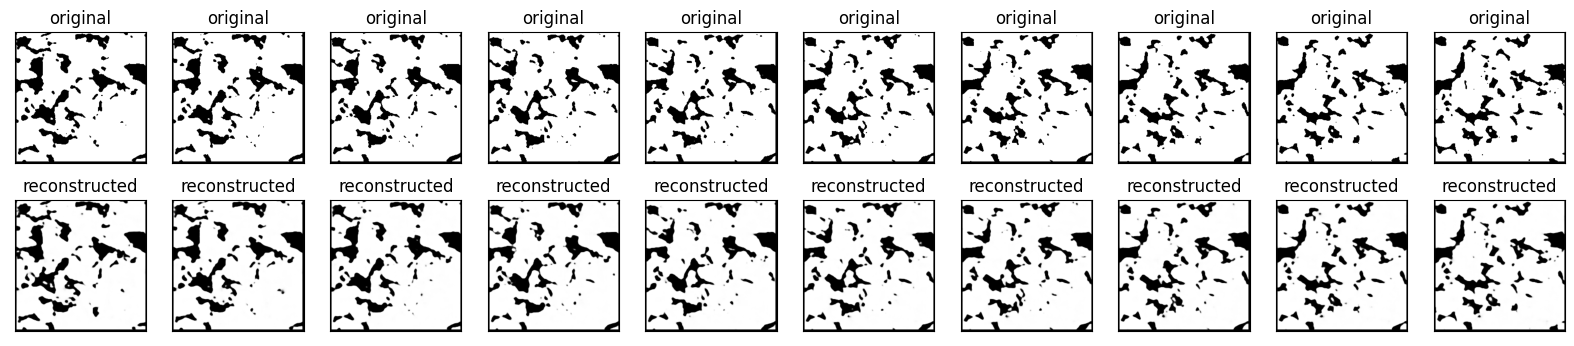

In [26]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(predicted[i].astype("float32"))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [27]:
testing = []
inputLayer = first[0]
for i in range(len(first)-1):
    testing.append(reconstruction.Generate.predict([inputLayer.reshape(1,256,256,1),Topredict[0].reshape(1,256,256,1)]))
    inputLayer = testing[-1]

In [28]:
len(testing)

249

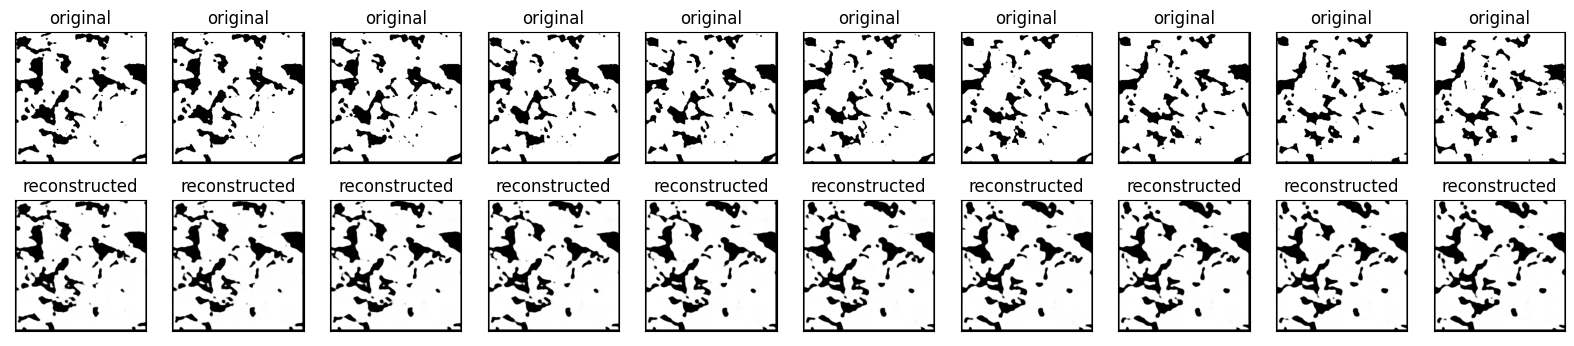

In [29]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [30]:
reconstruction.Generate.save('reconstruction_10batch_10epochs.h5')

D:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


NotImplementedError: Layers with arguments in `__init__` must override `get_config`.

In [31]:
file_path = "reconstructed.raw"
testing.insert(0, first[0].reshape(1,256,256,1))
print(len(testing))



250


In [33]:
final = np.array(testing,np.float32).reshape(250,256,256)
final.shape

(250, 256, 256)

In [34]:
file_path = "my_array.npy"
np.save("file", final)

In [35]:
final.tofile(file_path)

In [53]:
Volume = np.fromfile(file_path, dtype=np.uint8)
Volume = Volume.reshape(250,256,256)
Volume.shape

(250, 256, 256)